In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy
import xlrd
import plotly.graph_objs as go

In [2]:
df = pd.read_excel("2003-2016 Seed Potato Cert data v20191204_NO FL lines_Rioux 5AUG2020.xlsx", sheet_name="2003-2016 Seed Potato Cert")

In [3]:
df.shape

(7502, 147)

In [5]:
df.head()

,SummerID,CY,CERT_N,LNAME,SNAME,GCODE,VARIETY,VAR,V2,V3AR,...,winter_TBR,winter_TOTV,winter_CLASS,winter_GEN,winter_PAYING,winter_SF_PROG,winter_FY,winter_DIP,winter_AC_REJ,winter_CY
0,227,2007,107150,"Bula Potato Farms, Inc.",Bula Po,114,1975-11-15 00:00:00,1975-11-15 00:00:00,1975-11-15 00:00:00,1975-11-15 00:00:00,...,NaN,0.00,NaN,NaN,NaN,75-11-15 Summit Labs 2007,1,N,NaN,2007.0
1,272,2003,103207,"Bula Potato Farms, Inc.",Bula Po,114,A-88338-1,A-88338-1,A-88338-1,A-88338-1,...,NaN,0.00,NaN,NaN,NaN,A-88338-1 Manhattan 2003,4,NaN,0.0,2003.0
2,282,2003,103217,"Bula Potato Farms, Inc.",Bula Po,114,A-90586-11,A-90586-11,A-90586-11,A-90586-11,...,NaN,3.75,Certified,NaN,NaN,A-90586-11 Manhattan 2003,4,NaN,0.0,2003.0
3,3,2009,109003,"Guenthner Farms, Inc.",Guen Farm,149,A-91814-5,A-91814-5,A-91814-5,A-91814-5,...,NaN,0.00,Foundation,FY-2,NaN,A-91814-5 State Farm 2009,NaN,N,NaN,2009.0
4,10,2009,109003,"Guenthner Farms, Inc.",Guen Farm,149,A-91814-5,A-91814-5,A-91814-5,A-91814-5,...,NaN,0.00,Foundation,FY-2,NaN,A-91814-5 State Farm 2009,NaN,N,NaN,2009.0


### Data Validation

#### Inspection day

**DASP1** should be smaller than **DASP2**

In [16]:
df.loc[df["DAPS1"] > df["DAPS2"], df.columns.str.contains("DA")]

,DATE_1ST,DAPS1,DATE_2ND,DAPS2
6182,6/30/2005,38,6/16/2005,24


#### Source Year

**CY** should be larger than or equal to **S_YR** <br>

-CY: year entered certification program <br>
-S_YR: source year 

In [43]:
df[df["CY"] <df["S_YR"]]

,SummerID,CY,CERT_N,LNAME,SNAME,GCODE,VARIETY,VAR,V2,V3AR,...,winter_TBR,winter_TOTV,winter_CLASS,winter_GEN,winter_PAYING,winter_SF_PROG,winter_FY,winter_DIP,winter_AC_REJ,winter_CY


#### Possible redundant info for summer and winter

In [54]:
summer_columns = ["CERT_N",
"SNAME",
"GCODE",
"VARIETY",
"S_GRW",
"S_G",
"S_YR",
"S_GCODE",
"S_STATE"]

winter_columns = ["winter_{}".format(x) for x in summer_columns]
winter_columns

combined_columns =[]
for i in range(len(summer_columns)):
    combined_columns.append(summer_columns[i])
    combined_columns.append(winter_columns[i])
    
combined_columns

['CERT_N',
 'winter_CERT_N',
 'SNAME',
 'winter_SNAME',
 'GCODE',
 'winter_GCODE',
 'VARIETY',
 'winter_VARIETY',
 'S_GRW',
 'winter_S_GRW',
 'S_G',
 'winter_S_G',
 'S_YR',
 'winter_S_YR',
 'S_GCODE',
 'winter_S_GCODE',
 'S_STATE',
 'winter_S_STATE']

In [55]:
df[combined_columns]

,CERT_N,winter_CERT_N,SNAME,winter_SNAME,GCODE,winter_GCODE,VARIETY,winter_VARIETY,S_GRW,winter_S_GRW,S_G,winter_S_G,S_YR,winter_S_YR,S_GCODE,winter_S_GCODE,S_STATE,winter_S_STATE
0,107150,107150.0,Bula Po,Bula Po,114,114.0,1975-11-15 00:00:00,1975-11-15 00:00:00,"Summit Plant Labs, Inc.","Summit Plant Labs, Inc.",Summit Labs,Summit Labs,2007,2007.0,co02,co02,CO,CO
1,103207,103207.0,Bula Po,Bula Po,114,114.0,A-88338-1,A-88338-1,Kamps Seed Farm,Kamps Seed Farm,Manhattan,Manhattan,2003,2003.0,mt14,mt14,MT,MT
2,103217,103217.0,Bula Po,Bula Po,114,114.0,A-90586-11,A-90586-11,Kamps Seed Farm,Kamps Seed Farm,Manhattan,Manhattan,2003,2003.0,mt14,mt14,MT,MT
3,109003,109003.0,Guen Farm,Guen Farm,149,149.0,A-91814-5,A-91814-5,State Farm,State Farm,State Farm,State Farm,2009,2009.0,0,0,WI,WI
4,109003,109003.0,Guen Farm,Guen Farm,149,149.0,A-91814-5,A-91814-5,State Farm,State Farm,State Farm,State Farm,2009,2009.0,0,0,WI,WI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7497,110462,110462.0,Northsand,Northsand,196,196.0,Zebra,Zebra,"CETS, LLC Astrotuber","CETS, LLC Astrotuber",CETS,CETS,2008,2008.0,wi,wi,WI,WI
7498,108292,108292.0,Bula Po,Bula Po,114,114.0,Zebra,Zebra,"CETS, LLC Astrotuber","CETS, LLC Astrotuber",CETS,CETS,2008,2008.0,wi,wi,WI,WI
7499,108369,108369.0,Northsand,Northsand,196,196.0,Zebra,Zebra,"CETS, LLC Astrotuber","CETS, LLC Astrotuber",CETS,CETS,2008,2008.0,wi,wi,WI,WI
7500,108291,108291.0,Bula Po,Bula Po,114,114.0,Zeus,Zeus,"CETS, LLC Astrotuber","CETS, LLC Astrotuber",CETS,CETS,2008,2008.0,wi,wi,WI,WI


In [62]:
df.loc[:, (df.columns.str.contains("SR2")) | (df.columns.str.contains("SR1")) ]


,SR1_LR,SR1_MOS,SR1_ST,SR1_TOTV,SR1_MIX,SR2_LR,SR2_MOS,SR2_ST,SR2_TOTV,SR2_BRR,SR2_MIX
0,0.0,0.00,0.0,0.00,0.00000,0.0,0.00,0.0,0.00,0.0,0.00000
1,0.0,0.00,0.0,0.00,0.20202,0.0,0.00,0.0,0.00,0.0,0.00000
2,0.0,0.44,0.0,0.44,0.00000,0.0,0.44,0.0,0.44,0.0,0.03788
3,0.0,0.00,0.0,0.00,0.00000,0.0,0.00,0.0,0.00,0.0,0.00000
4,0.0,0.00,0.0,0.00,0.00000,0.0,0.00,0.0,0.00,0.0,0.00000
...,...,...,...,...,...,...,...,...,...,...,...
7497,0.0,0.00,0.0,0.00,0.00000,0.0,0.00,0.0,0.00,0.0,0.00000
7498,0.0,0.00,0.0,0.00,0.00000,0.0,0.00,0.0,0.00,0.0,0.00000
7499,0.0,0.00,0.0,0.00,0.00000,0.0,0.00,0.0,0.00,0.0,0.00000
7500,0.0,0.00,0.0,0.00,0.00000,0.0,0.00,0.0,0.00,0.0,0.00000


In [100]:
frequent_state = df["S_STATE"].value_counts()[:8].index.to_list()
frequent_state

['WI', 'NY', 'CO', 'MN', 'ND', 'MT', 'MI', 'NE']

In [88]:
df.columns[df.columns.str.contains("SR1")]

Index(['SR1_LR', 'SR1_MOS', 'SR1_ST', 'SR1_TOTV', 'SR1_MIX'], dtype='object')

In [94]:
target_virus = ['SR1_ST','SR1_MIX',"SR1_LR"]

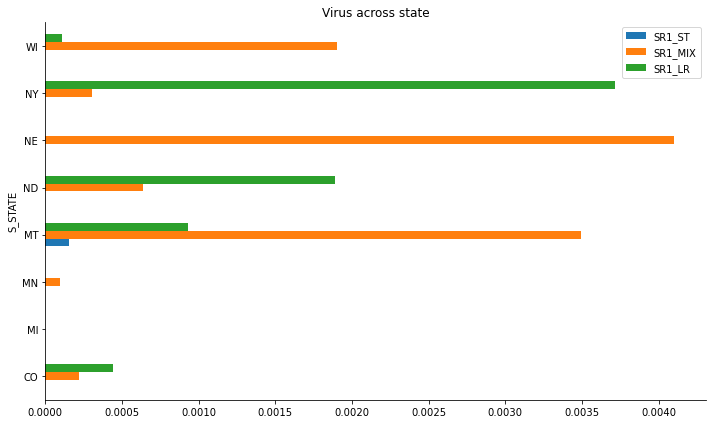

In [128]:
fig, ax = plt.subplots(figsize = (10,6))
df[df["S_STATE"].isin(frequent_state)].groupby("S_STATE").mean()[target_virus].plot(kind = "barh", ax = ax)
ax.tick_params(axis='x', rotation=0)
ax.set_title("Virus across state")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()

plt.savefig("Virus_across_state")

In [104]:
frequent_variety = df["VARIETY"].value_counts()[:15].index.tolist()
frequent_variety

['Dark Red Norland',
 'Atlantic',
 'Goldrush',
 'Snowden',
 'Superior',
 'Red Norland',
 'Russet Norkotah',
 'Pike',
 'MegaChip',
 'Silverton',
 'Yukon Gold',
 'Russet Norkotah Sel 8',
 'Red LaSoda 10-3',
 'Freedom Russet',
 'Lamoka']

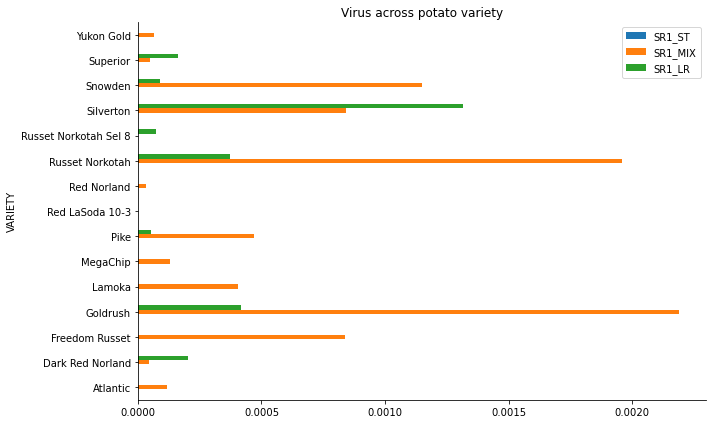

In [127]:
fig, ax = plt.subplots(figsize = (10,6))
df[df["VARIETY"].isin(frequent_variety)].groupby("VARIETY").mean()[target_virus].plot(kind = "barh", ax = ax)
ax.tick_params(axis='x', rotation=0)
ax.tick_params(axis="y", rotation = 0)
ax.set_title("Virus across potato variety")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig("Virus_across_potato_variety")